# Object Detection With Retinanet


### Installing Earlier dist of pytorch which is compatible with Detectron 2

In [1]:
pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████▎ | 834.1 MB 1.6 MB/s eta 0:00:30tcmalloc: large alloc 1147494400 bytes == 0x653f8000 @  0x7febb38b2615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 881.9 MB 8.2 kB/s 
     |████████████████████████████████| 23.3 MB 100.2 MB/s 
     |████████████████████████████████| 2.9 MB 70.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Su

#### Cloning Detectron2 Git Repo 

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 3.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=69173495794a6a8a7388609265ec3ac9d103a3f81a24844b3d0f76287fa7a7a7
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14718, done.
remote: Total 14718 (delta 0), reused 0 (delta 0), pack-reused 14718
Receivi

#### Checking Cuda and torch version because the installation for different version is different

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.10 ; cuda:  cu102
detectron2: 0.6


#### Installing Detectron2 compatible with 1.10 pytorch and 10.2 cuda

In [4]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html
     |████████████████████████████████| 6.6 MB 903 kB/s 
     |████████████████████████████████| 130 kB 5.0 MB/s 
  Attempting uninstall: black
    Found existing installation: black 22.12.0
    Uninstalling black-22.12.0:
      Successfully uninstalled black-22.12.0


#### Importing Dependencies

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

#### Mounting Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data Paths

In [7]:
train_path = '/content/drive/MyDrive/Colab Notebooks/FruitDataset/train'
train_gt = '/content/drive/MyDrive/Colab Notebooks/FruitDataset/gt/train.json'
test_path = '/content/drive/MyDrive/Colab Notebooks/FruitDataset/test'
test_gt = '/content/drive/MyDrive/Colab Notebooks/FruitDataset/gt/test.json'

### Registering datasets

In [8]:
register_coco_instances("FruitDataset", {}, train_gt, train_path)
register_coco_instances("FruitDataset_test", {}, test_gt, test_path)

In [9]:

sample_metadata = MetadataCatalog.get("FruitDataset")
dataset_dicts = DatasetCatalog.get("FruitDataset")
sample_metadata_test = MetadataCatalog.get("FruitDataset_test")
dataset_dicts_test = DatasetCatalog.get("FruitDataset_test")

WARNING [12/28 16:01:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/28 16:01:50 d2.data.datasets.coco]: Loaded 207 images in COCO format from /content/drive/MyDrive/Colab Notebooks/FruitDataset/gt/train.json
WARNING [12/28 16:01:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/28 16:01:51 d2.data.datasets.coco]: Loaded 56 images in COCO format from /content/drive/MyDrive/Colab Notebooks/FruitDataset/gt/test.json


#### Plotting Examples

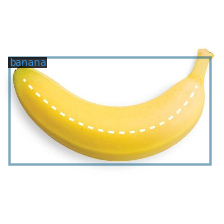

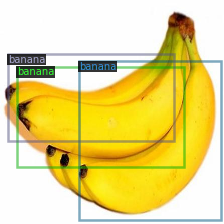

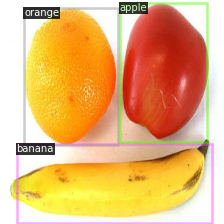

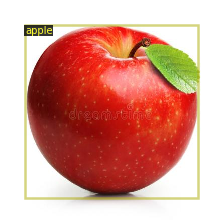

In [10]:
for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#### Setting up Training Configuration and loops

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("../Base-RetinaNet.yaml"))
cfg.DATASETS.TRAIN = ("FruitDataset",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("detectron2://ImageNetPretrained/MSRA/R-50.pkl")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 200   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[12/28 16:01:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:04, 41.8MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/28 16:02:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/28 16:02:22 d2.utils.events]:  eta: 0:02:01  iter: 19  total_loss: 1.679  loss_cls: 1.183  loss_box_reg: 0.4493  loss_rpn_cls: 0.004576  loss_rpn_loc: 0.007884  time: 0.6542  data_time: 0.0627  lr: 0.00019181  max_mem: 3162M
[12/28 16:02:35 d2.utils.events]:  eta: 0:01:48  iter: 39  total_loss: 1.039  loss_cls: 0.4541  loss_box_reg: 0.5439  loss_rpn_cls: 0.002839  loss_rpn_loc: 0.009396  time: 0.6552  data_time: 0.0276  lr: 0.00039161  max_mem: 3162M
[12/28 16:02:49 d2.utils.events]:  eta: 0:01:35  iter: 59  total_loss: 0.8065  loss_cls: 0.3007  loss_box_reg: 0.5044  loss_rpn_cls: 0.00281  loss_rpn_loc: 0.008151  time: 0.6569  data_time: 0.0153  lr: 0.00059141  max_mem: 3162M
[12/28 16:03:02 d2.utils.events]:  eta: 0:01:21  iter: 79  total_loss: 0.7548  loss_cls: 0.2093  loss_box_reg: 0.5106  loss_rpn_cls: 0.004147  loss_rpn_loc: 0.007657  time: 0.6588  data_time: 0.0210  lr: 0.00079121  max_mem: 3162M
[12/28 16:03:16 d2.utils.events]:  eta: 0:01:08  iter: 99  total_loss: 0.5857  l

### Loading Saved model after training for inference

In [13]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("FruitDataset",)
predictor = DefaultPredictor(cfg)

[12/28 16:04:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


##### Plotting Inference Examples

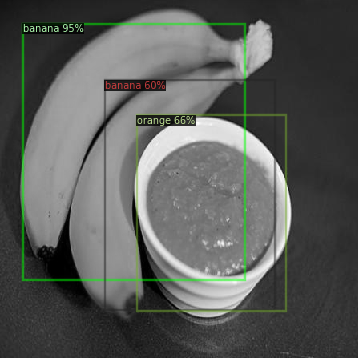

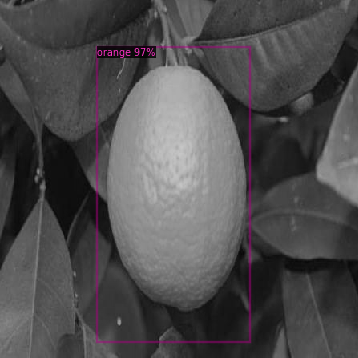

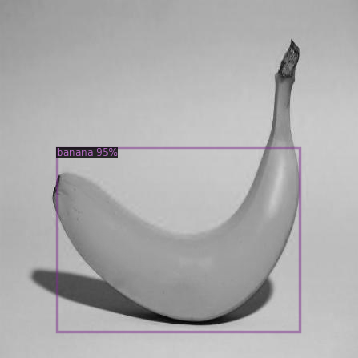

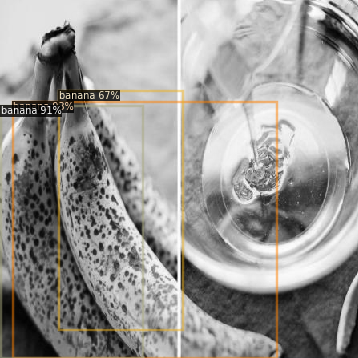

In [14]:

from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

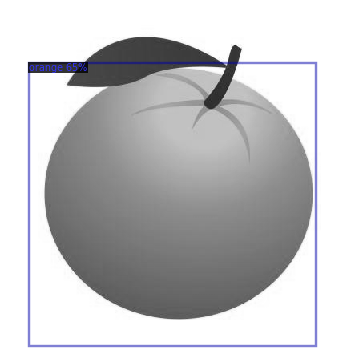

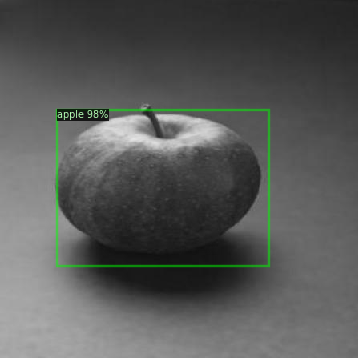

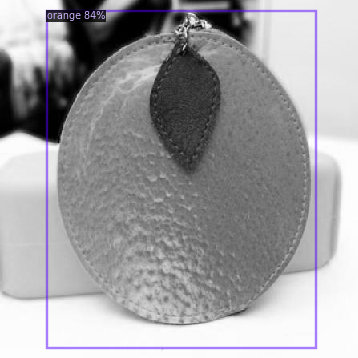

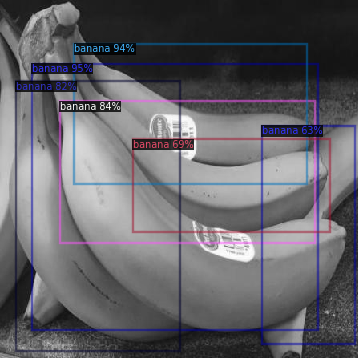

In [17]:
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])